<a href="https://colab.research.google.com/github/pgssanjana/micro_projects/blob/main/test_phase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_dataset_path = '/content/drive/MyDrive/gsoc/model/train/'
validation_dataset_path = '/content/drive/MyDrive/gsoc/model/test/'

In [ ]:
img=cv2.imread('/content/drive/MyDrive/gsoc/model/train/cleaning-coag-imgs/frame0.jpg')
img.shape

(480, 854, 3)

In [ ]:
IMG_WIDTH = 480
IMG_HEIGHT = 854
BATCH_SIZE = 32

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 3455 images belonging to 6 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 1210 images belonging to 6 classes.


In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : calottriangle-diss-imgs
1 : cleaning-coag-imgs
2 : clipping-cutting-imgs
3 : galbladder-disc-img
4 : galbladder-pack-imgs
5 : prep-img


In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()


In [ ]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=6, activation='softmax')
    ])
    
    return model

In [ ]:
cnn_model = create_model()
print(cnn_model.summary())

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [ ]:
x,y=validation_generator.next()
x.shape


(32, 480, 854, 3)

In [ ]:
import tensorflow as tf
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5',
                              monitor='val_loss',
                             verbose=1, 
                             save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model=ResNet50(include_top=False,weights='imagenet',input_shape=(480,854,3))

av1=GlobalAveragePooling2D()(base_model.output)
fc1 = Dense(256,activation='relu')(av1)
fc2=Dense(1,activation='sigmoid')(fc1)

model_new=Model(inputs=base_model.input,outputs=fc2)

for layer in base_model.layers:
  layer.trainable=False

adam=Adam(learning_rate=0.00003)
model_new.compile(optimizer=Adam(lr=0.003),metrics=['accuracy'],loss='binary_crossentropy')

History = model_new.fit(train_generator,validation_data=validation_generator,epochs=10,verbose=1,callbacks=my_callbacks,steps_per_epoch=32)

Epoch 1/10
21/32 [==================>...........] - ETA: 35s - loss: 0.8561 - accuracy: 0.8016

KeyboardInterrupt: ignored

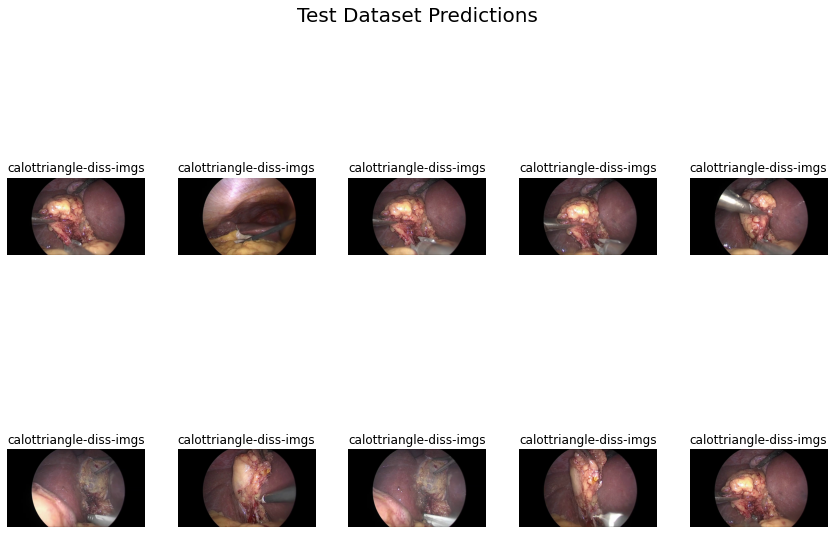

In [ ]:
predictions = model_new.predict(validation_generator)
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(validation_generator[4][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [ ]:
# loading library
import pickle
# create an iterator object with write permission - model.pkl
with open('model_pkl', 'wb') as files:
    pickle.dump(model_new, files)

In [ ]:
adam=Adam(learning_rate=0.001)
cnn_model.compile(optimizer=adam,metrics=['accuracy'],loss=CategoricalCrossentropy())

History = cnn_model.fit(train_generator,validation_data=validation_generator,epochs=10,verbose=1,callbacks=my_callbacks,steps_per_epoch=32)

In [ ]:
optimizer = Adam(learning_rate=0.001)

In [ ]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
history = cnn_model.fit(train_generator, epochs=10, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])


Epoch 1/10


ResourceExhaustedError: ignored